# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://deep-learning-su.github.io/assignment-requirements/) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from deep_learning_su.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'deep_learning_su/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


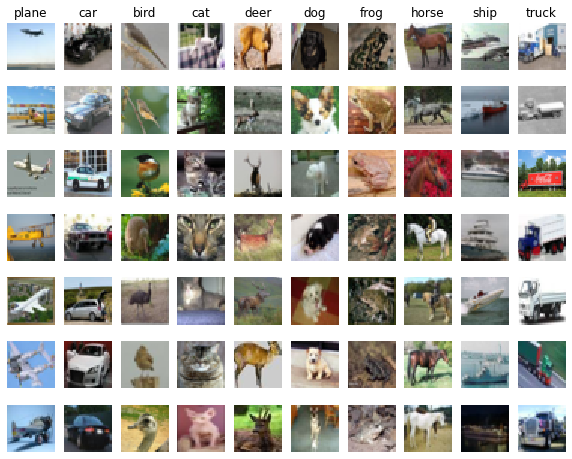

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


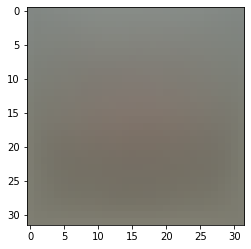

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **deep_learning_su/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from deep_learning_su.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
print('matrix min: %f' % np.min(W))
print('X min: %f' % np.min(X_dev))

loss: 8.902665
matrix min: -0.000420
X min: -140.178551


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from deep_learning_su.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

check
numerical: -5.328290 analytic: -5.328290, relative error: 2.873579e-11
numerical: 2.654244 analytic: 2.654244, relative error: 1.001822e-10
numerical: 17.907988 analytic: 17.907988, relative error: 4.382351e-11
numerical: 19.100250 analytic: 19.100250, relative error: 2.861943e-12
numerical: -26.556482 analytic: -26.556482, relative error: 8.147842e-12
numerical: 25.445105 analytic: 25.445105, relative error: 3.968007e-12
numerical: 0.404839 analytic: 0.404839, relative error: 4.864261e-10
numerical: -2.239440 analytic: -2.239440, relative error: 1.578914e-11
numerical: -2.170006 analytic: -2.170006, relative error: 8.958709e-11
numerical: 6.888209 analytic: 6.888209, relative error: 1.422628e-11
check
numerical: 21.957084 analytic: 21.957084, relative error: 1.306831e-11
numerical: -2.525645 analytic: -2.525645, relative error: 8.760136e-11
numerical: -6.737897 analytic: -6.737897, relative error: 2.965913e-12
numerical: 13.080938 analytic: 13.080938, relative error: 1.305936e-1

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*
The SVM loss function is not differentiable since it is not defined for all values of W. This is due to the fact that we are taking max(0, w_j*x - w_yi*x + delta. The point when the second argument becomes 0 is non-differentiable and would be computed differently when using the numerical approach. It would try to calculate the next functional value with a small increment of the variable, but in practice, there is a vertical "switch" to zero. This means that all the values between the last positive value and zero are not defined, which renders the function non differentiable. This shouldn't be too much of an issue if we keep the gradient small enough.

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from deep_learning_su.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.902665e+00 computed in 0.111651s
Vectorized loss: 8.902665e+00 computed in 0.033023s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.110446s
Vectorized loss and gradient: computed in 0.033314s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from deep_learning_su.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 795.102200
iteration 100 / 1500: loss 290.334462
iteration 200 / 1500: loss 108.691047
iteration 300 / 1500: loss 43.365084
iteration 400 / 1500: loss 18.863067
iteration 500 / 1500: loss 10.986030
iteration 600 / 1500: loss 7.001617
iteration 700 / 1500: loss 6.217934
iteration 800 / 1500: loss 5.205345
iteration 900 / 1500: loss 5.141630
iteration 1000 / 1500: loss 5.138247
iteration 1100 / 1500: loss 5.817384
iteration 1200 / 1500: loss 5.914098
iteration 1300 / 1500: loss 5.553696
iteration 1400 / 1500: loss 5.095956
That took 20.362850s


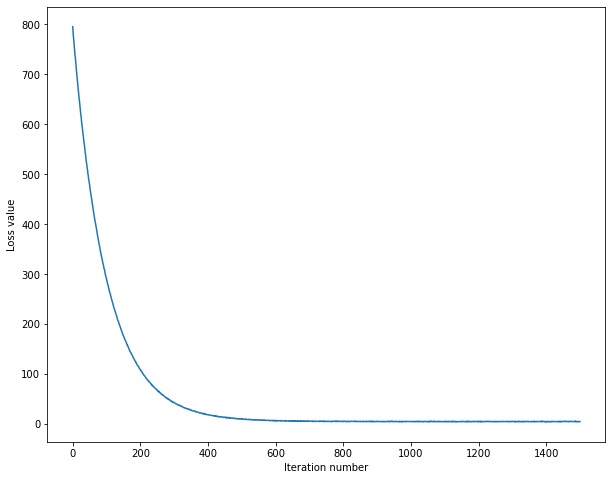

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [36]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(np.equal(y_train, y_train_pred))))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(np.equal(y_val, y_val_pred))))

training accuracy: 0.371449
validation accuracy: 0.375000


In [27]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8, 3e-7]
regularization_strengths = [1.5e3, 3e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
num_rates = 5
rates_start = learning_rates[0]
rates_stop = learning_rates[1]
learning_rates = np.arange(rates_start, rates_stop, (rates_stop - rates_start)/(num_rates))

num_strengths = 5
strengths_start = regularization_strengths[0]
strengths_stop = regularization_strengths[1]
regularization_strengths = np.arange(strengths_start, strengths_stop, (strengths_stop-strengths_start)/(num_strengths))

print("learning rates ", learning_rates)
for lr in learning_rates:
    for rs in regularization_strengths:
        
        svm = LinearSVM()
        svm.train(X_train, y_train, lr, rs, num_iters=5000, verbose=True)
        y_val_pred = svm.predict(X_val)
        eval_acc = np.mean(np.equal(y_val_pred, y_val))
        
        y_train_pred = svm.predict(X_train)
        train_acc =np.mean(np.equal(y_train_pred, y_train))
        
        results[(lr, rs)] = (train_acc, eval_acc)
        print("new acc ", eval_acc)
        print("lr, rs", lr, rs)
        if eval_acc > best_val:
            
            best_val = eval_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rates  [1.00e-08 6.80e-08 1.26e-07 1.84e-07 2.42e-07]
iteration 0 / 5000: loss 72.651749
iteration 100 / 5000: loss 63.487519
iteration 200 / 5000: loss 59.892404
iteration 300 / 5000: loss 60.259383
iteration 400 / 5000: loss 57.977348
iteration 500 / 5000: loss 57.116309
iteration 600 / 5000: loss 54.450705
iteration 700 / 5000: loss 54.747032
iteration 800 / 5000: loss 53.388884
iteration 900 / 5000: loss 51.463121
iteration 1000 / 5000: loss 53.083543
iteration 1100 / 5000: loss 53.009722
iteration 1200 / 5000: loss 51.719637
iteration 1300 / 5000: loss 51.212122
iteration 1400 / 5000: loss 51.147860
iteration 1500 / 5000: loss 51.726576
iteration 1600 / 5000: loss 50.262271
iteration 1700 / 5000: loss 51.036738
iteration 1800 / 5000: loss 49.215811
iteration 1900 / 5000: loss 48.318825
iteration 2000 / 5000: loss 49.824191
iteration 2100 / 5000: loss 48.962663
iteration 2200 / 5000: loss 47.656281
iteration 2300 / 5000: loss 48.624068
iteration 2400 / 5000: loss 49.204628

iteration 1000 / 5000: loss 291.693606
iteration 1100 / 5000: loss 264.443729
iteration 1200 / 5000: loss 240.879597
iteration 1300 / 5000: loss 219.356749
iteration 1400 / 5000: loss 199.790734
iteration 1500 / 5000: loss 180.654798
iteration 1600 / 5000: loss 163.775280
iteration 1700 / 5000: loss 149.275790
iteration 1800 / 5000: loss 136.415989
iteration 1900 / 5000: loss 123.050659
iteration 2000 / 5000: loss 112.868214
iteration 2100 / 5000: loss 103.172761
iteration 2200 / 5000: loss 93.185340
iteration 2300 / 5000: loss 84.974551
iteration 2400 / 5000: loss 78.284621
iteration 2500 / 5000: loss 71.088452
iteration 2600 / 5000: loss 65.267373
iteration 2700 / 5000: loss 59.784410
iteration 2800 / 5000: loss 54.605282
iteration 2900 / 5000: loss 49.465101
iteration 3000 / 5000: loss 45.006569
iteration 3100 / 5000: loss 41.969890
iteration 3200 / 5000: loss 38.190057
iteration 3300 / 5000: loss 35.333734
iteration 3400 / 5000: loss 33.085950
iteration 3500 / 5000: loss 29.746756


iteration 2500 / 5000: loss 5.122214
iteration 2600 / 5000: loss 4.718846
iteration 2700 / 5000: loss 5.151138
iteration 2800 / 5000: loss 4.713006
iteration 2900 / 5000: loss 5.570645
iteration 3000 / 5000: loss 5.416638
iteration 3100 / 5000: loss 4.515280
iteration 3200 / 5000: loss 5.141225
iteration 3300 / 5000: loss 4.883310
iteration 3400 / 5000: loss 4.655073
iteration 3500 / 5000: loss 5.418820
iteration 3600 / 5000: loss 4.972219
iteration 3700 / 5000: loss 4.723999
iteration 3800 / 5000: loss 5.217366
iteration 3900 / 5000: loss 4.538652
iteration 4000 / 5000: loss 5.374321
iteration 4100 / 5000: loss 5.145114
iteration 4200 / 5000: loss 4.726120
iteration 4300 / 5000: loss 4.941835
iteration 4400 / 5000: loss 5.754369
iteration 4500 / 5000: loss 5.530563
iteration 4600 / 5000: loss 5.125309
iteration 4700 / 5000: loss 5.239706
iteration 4800 / 5000: loss 5.205048
iteration 4900 / 5000: loss 5.271721
new acc  0.388
lr, rs 6.8e-08 18600.0
iteration 0 / 5000: loss 765.810573
i

iteration 4200 / 5000: loss 5.222014
iteration 4300 / 5000: loss 4.912163
iteration 4400 / 5000: loss 5.672291
iteration 4500 / 5000: loss 5.246310
iteration 4600 / 5000: loss 5.302818
iteration 4700 / 5000: loss 5.102372
iteration 4800 / 5000: loss 5.246389
iteration 4900 / 5000: loss 4.942917
new acc  0.385
lr, rs 1.2600000000000002e-07 12900.0
iteration 0 / 5000: loss 596.999606
iteration 100 / 5000: loss 231.691533
iteration 200 / 5000: loss 93.790981
iteration 300 / 5000: loss 38.917896
iteration 400 / 5000: loss 18.000531
iteration 500 / 5000: loss 10.029614
iteration 600 / 5000: loss 7.772519
iteration 700 / 5000: loss 5.964909
iteration 800 / 5000: loss 5.570436
iteration 900 / 5000: loss 5.512427
iteration 1000 / 5000: loss 5.159809
iteration 1100 / 5000: loss 5.129921
iteration 1200 / 5000: loss 5.126716
iteration 1300 / 5000: loss 5.077696
iteration 1400 / 5000: loss 5.217663
iteration 1500 / 5000: loss 5.415990
iteration 1600 / 5000: loss 5.442969
iteration 1700 / 5000: los

iteration 800 / 5000: loss 5.222217
iteration 900 / 5000: loss 4.829344
iteration 1000 / 5000: loss 5.160967
iteration 1100 / 5000: loss 5.382081
iteration 1200 / 5000: loss 5.157400
iteration 1300 / 5000: loss 5.061909
iteration 1400 / 5000: loss 4.644348
iteration 1500 / 5000: loss 5.118644
iteration 1600 / 5000: loss 5.607545
iteration 1700 / 5000: loss 4.898496
iteration 1800 / 5000: loss 5.443879
iteration 1900 / 5000: loss 4.510713
iteration 2000 / 5000: loss 4.915768
iteration 2100 / 5000: loss 4.948996
iteration 2200 / 5000: loss 4.899554
iteration 2300 / 5000: loss 4.606602
iteration 2400 / 5000: loss 5.240879
iteration 2500 / 5000: loss 5.224009
iteration 2600 / 5000: loss 5.070833
iteration 2700 / 5000: loss 5.117641
iteration 2800 / 5000: loss 4.639553
iteration 2900 / 5000: loss 4.999017
iteration 3000 / 5000: loss 4.663139
iteration 3100 / 5000: loss 5.470396
iteration 3200 / 5000: loss 4.729208
iteration 3300 / 5000: loss 5.383011
iteration 3400 / 5000: loss 4.172382
ite

iteration 2600 / 5000: loss 5.757121
iteration 2700 / 5000: loss 4.580606
iteration 2800 / 5000: loss 4.608088
iteration 2900 / 5000: loss 4.879136
iteration 3000 / 5000: loss 4.638913
iteration 3100 / 5000: loss 5.179526
iteration 3200 / 5000: loss 5.262053
iteration 3300 / 5000: loss 5.426555
iteration 3400 / 5000: loss 5.305099
iteration 3500 / 5000: loss 5.050867
iteration 3600 / 5000: loss 5.198774
iteration 3700 / 5000: loss 4.869120
iteration 3800 / 5000: loss 4.770160
iteration 3900 / 5000: loss 5.207097
iteration 4000 / 5000: loss 5.118975
iteration 4100 / 5000: loss 5.607433
iteration 4200 / 5000: loss 4.636645
iteration 4300 / 5000: loss 4.597117
iteration 4400 / 5000: loss 4.621083
iteration 4500 / 5000: loss 5.051545
iteration 4600 / 5000: loss 4.827540
iteration 4700 / 5000: loss 4.543221
iteration 4800 / 5000: loss 5.571830
iteration 4900 / 5000: loss 4.635975
new acc  0.379
lr, rs 2.42e-07 7200.0
iteration 0 / 5000: loss 417.888885
iteration 100 / 5000: loss 118.978612


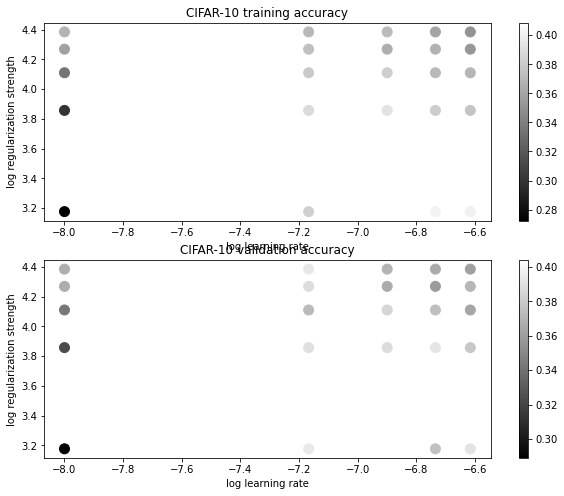

In [28]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [29]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.392000


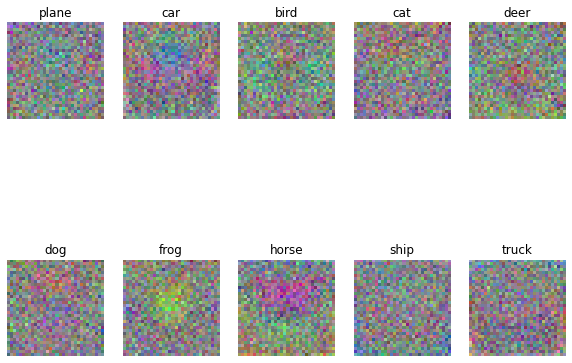

In [30]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

In [ ]:
On first sight, the weights look like they contain just noise. If one takes a close look, however, it can be seen that there are areas within the matrices that resemble some shapes and consistency. 
When I ran the training with less iterations I would have described the weight matrices as almost only noise. 

The reason for the formed shapes that are observable is that the algorithm has learned patterns that occur in the different classes and define them. 